In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import math
import pandas as pd
import datetime as dt
import sys
import configparser
from PIL import Image
import subprocess
import micaplotutils as plotutils
import micametadata as metadata
import micautils as msutils
import pyexiv2

In [3]:
def plotwithcolorbar(img, title=''):
    ##Plot an image with a colorbar
    fig, axis = plt.subplots(1, 1, figsize=(8, ppip6))
    rad2 = axis.imshow(img)
    axis.set_title(title)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    fig.colorbar(rad2, cax=cax)
    fig1=plt.gcf()
    plt.tight_layout()
    plt.show()
    return fig1
def colormap(cmap):
    ##Set the defalut plotting colormap
    ##Could be one of 'gray, viridis, plasma, inferno, magma, nipy_spectral'
    plt.set_cmap(cmap)
def load_metadata(image_name):
	""" Wrapper to return metadata from exiftool """
	meta = metadata.Metadata(image_name, exiftoolPath=exiftoolPath)
	return meta
def load_panel_factors(panel_cal_fn):
	"""
	Load reflectance panel calibration data.
	Expects a CSV file with columns 'band_number', 'band_name' and 'factor', and rows named using 
	the RedEdge camera bands written into image metadata.
	:param panel_cal_fn: File path and name of CSV file to load.
	:type panel_cal_fn: str
	:returns: Series representing CSV file.
	:rtype: pd.Series
	"""

	panel_cal = pd.read_csv(panel_cal_fn, index_col='band_name').squeeze()
	panel_cal.name = panel_cal_fn
	return panel_cal

In [4]:
def load_panel_factors(panel_cal_fn):
    """
    Load reflectance panel calibration data.
    Expects a CSV file with columns 'band_number', 'band_name' and 'factor', and rows named using 
    the RedEdge camera bands written into image metadata.
    :param panel_cal_fn: File path and name of CSV file to load.
    :type panel_cal_fn: str
    :returns: Series representing CSV file.
    :rtype: pd.Series
    """

    panel_cal = pd.read_csv(panel_cal_fn, index_col='band_name').squeeze()
    panel_cal.name = panel_cal_fn
    return panel_cal
def panelimage(panel_cal, image_name, image_path, plot_steps=False):

    image = os.path.join(image_path, image_name)
	# Read raw image DN values
	# reads 16 bit tif - this will likely not work for 12 bit images
    imageRaw = plt.imread(image)

	# Display the image
    if plot_steps:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(imageRaw, cmap='gray')
        plt.show()
        fig = plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar')

	# Load metadata
    meta = metadata.Metadata(image)
    cameraMake = meta.get_item('EXIF:Make')
    cameraModel = meta.get_item('EXIF:Model')
    bandName = meta.get_item('XMP:BandName')

	# Correct the image of refl panel
    radianceImage, L, V, R = msutils.raw_image_to_radiance(meta, imageRaw)
    if plot_steps:
        plotutils.plotwithcolorbar(V,'Vignette Factor')
        plotutils.plotwithcolorbar(R,'Row Gradient Factor')
        plotutils.plotwithcolorbar(V*R,'Combined Corrections')
        plotutils.plotwithcolorbar(L,'Vignette and row gradient corrected raw values')

	# Display the corrected refl panel image
    plotutils.plotwithcolorbar(radianceImage,'All factors applied and scaled to radiance')

In [5]:
panel_cal = load_panel_factors("C:/Users/Sara/panel_cal.csv")

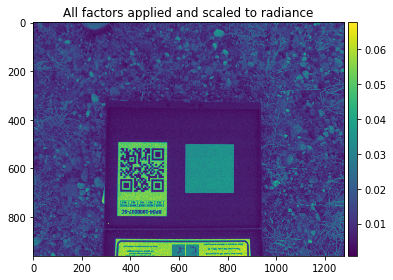

In [6]:
image_path = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '0006SET', '000','Panel Images','USE THESE')
panelimage(panel_cal,'IMG_0338_5.tif',image_path)

In [7]:
def radrefl_factor(panel_cal, image_name, image_path, ulx, uly, lrx, lry, plot_steps=False,cal_model_fn=None, return_date=False):
    image = os.path.join(image_path, image_name)
	# Read raw image DN values
	# reads 16 bit tif - this will likely not work for 12 bit images
    imageRaw = plt.imread(image)

	# Display the image
    if plot_steps:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(imageRaw, cmap='gray')
        plt.show()
        fig = plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar')

	# Load metadata
    meta = metadata.Metadata(image)
    cameraMake = meta.get_item('EXIF:Make')
    cameraModel = meta.get_item('EXIF:Model')
    bandName = meta.get_item('XMP:BandName')
    
	# Correct the image of refl panel
    radianceImage, L, V, R = msutils.raw_image_to_radiance(meta, imageRaw)
    if plot_steps:
        plotutils.plotwithcolorbar(V,'Vignette Factor')
        plotutils.plotwithcolorbar(R,'Row Gradient Factor')
        plotutils.plotwithcolorbar(V*R,'Combined Corrections')
        plotutils.plotwithcolorbar(L,'Vignette and row gradient corrected raw values')

	# Mark points on image
    markedImg = radianceImage.copy()
    ulx = ulx
    uly = uly
    lrx = lrx
    lry = lry
    if plot_steps:
		# Plot rectangle on image
        cv2.rectangle(markedImg,(ulx,uly),(lrx,lry),(0,255,0),3)
        plotutils.plotwithcolorbar(markedImg, 'Panel region in radiance image')

	# Select panel region from radiance image
    panelRegion = radianceImage[uly:lry, lrx:ulx]
    meanRadiance = panelRegion.mean()
    print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance))
    panelReflectance = panel_cal.loc[bandName].factor
    radianceToReflectance = panelReflectance / meanRadiance
    print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance))

	# Create reflectance image
    reflectanceImage = radianceImage * radianceToReflectance
    if plot_steps:
        plotutils.plotwithcolorbar(reflectanceImage, 'Converted Reflectance Image')

	# Blur the panel to check for trends - we want a consistent reflectance.
    panelRegionRefl = reflectanceImage[uly:lry,lrx:ulx]
    panelRegionReflBlur = cv2.GaussianBlur(panelRegionRefl,(55,55),5)
    plotutils.plotwithcolorbar(panelRegionReflBlur, 'Smoothed panel region in reflectance image')
    print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.min()))
    print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.max()))
    print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.mean()))
    print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl.std()))

    if return_date:
		# Get time of image acquisition
        create_date = dt.datetime.strptime(meta.get_item('EXIF:CreateDate'), '%Y:%m:%d %H:%M:%S')
        return radianceToReflectance, create_date
    else:
        return radianceToReflectance

Mean Radiance in panel region: 0.035 W/m^2/nm/sr
Radiance to reflectance conversion factor: 14.111


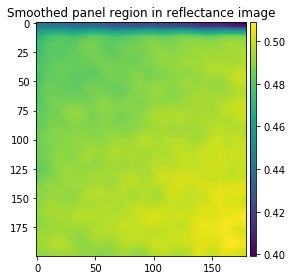

Min Reflectance in panel region: 0.10
Max Reflectance in panel region: 0.59
Mean Reflectance in panel region: 0.49
Standard deviation in region: 0.0341


14.110821482672005

In [8]:
image_path = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '0006SET', '000','Panel Images','USE THESE')
radrefl_factor(panel_cal,'IMG_0338_5.tif',image_path,810,500,630,700,plot_steps=False,cal_model_fn=None, return_date=False)

In [9]:
def copyMeta(inputIMGpath,outputIMGpath):
    original_meta = pyexiv2.ImageMetadata(inputIMGpath)
    original_meta.read()
    new_meta = pyexiv2.ImageMetadata(outputIMGpath)
    new_meta.read()
    original_meta.copy(new_meta,comment=False)
    new_meta.write()

In [40]:
def calibrate_correct_image(raw_image, inputpath, outputpath, figname, rad2refl_factor):
    image = plt.imread(os.path.join(inputpath,raw_image))
    meta = metadata.Metadata(os.path.join(inputpath,raw_image))
    fl_im_rad, _, _, _ = msutils.raw_image_to_radiance(meta, image)
    fl_im_refl = fl_im_rad * rad2refl_factor
    im = Image.fromarray(fl_im_refl)
    im.save(os.path.join(outputpath,figname),format ='tiff')
    copyMeta(os.path.join(inputpath,raw_image),os.path.join(outputpath,figname))
    return 

In [41]:
inputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '0006SET', '000','Panel Images','USE THESE')
outputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '0006SET', '000','Panel Images','USE THESE')
calibrate_correct_image('IMG_0338_5.tif', inputpath, outputpath, 'correct.tif', 14.110821482672005)